In [27]:
# Run this cell to import pyspark and to define start_spark() and stop_spark()

import findspark

findspark.init()

import getpass
import pandas
import pyspark
import random
import re

from IPython.display import display, HTML
from pyspark import SparkContext
from pyspark.sql import SparkSession


# Functions used below

def username():
    """Get username with any domain information removed.
    """

    return re.sub('@.*', '', getpass.getuser())


def dict_to_html(d):
    """Convert a Python dictionary into a two column table for display.
    """

    html = []

    html.append(f'<table width="100%" style="width:100%; font-family: monospace;">')
    for k, v in d.items():
        html.append(f'<tr><td style="text-align:left;">{k}</td><td>{v}</td></tr>')
    html.append(f'</table>')

    return ''.join(html)


def show_as_html(df, n=20):
    """Leverage existing pandas jupyter integration to show a spark dataframe as html.
    
    Args:
        n (int): number of rows to show (default: 20)
    """

    display(df.limit(n).toPandas())

    
def display_spark():
    """Display the status of the active Spark session if one is currently running.
    """
    
    if 'spark' in globals() and 'sc' in globals():

        name = sc.getConf().get("spark.app.name")
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:green">active</span></b>, look for <code>{name}</code> under the running applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'<li><a href="{sc.uiWebUrl}" target="_blank">Spark Application UI</a></li>',
            f'</ul>',
            f'<p><b>Config</b></p>',
            dict_to_html(dict(sc.getConf().getAll())),
            f'<p><b>Notes</b></p>',
            f'<ul>',
            f'<li>The spark session <code>spark</code> and spark context <code>sc</code> global variables have been defined by <code>start_spark()</code>.</li>',
            f'<li>Please run <code>stop_spark()</code> before closing the notebook or restarting the kernel or kill <code>{name}</code> by hand using the link in the Spark UI.</li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))
        
    else:
        
        html = [
            f'<p><b>Spark</b></p>',
            f'<p>The spark session is <b><span style="color:red">stopped</span></b>, confirm that <code>{username() + " (jupyter)"}</code> is under the completed applications section in the Spark UI.</p>',
            f'<ul>',
            f'<li><a href="http://mathmadslinux2p.canterbury.ac.nz:8080/" target="_blank">Spark UI</a></li>',
            f'</ul>',
        ]
        display(HTML(''.join(html)))


# Functions to start and stop spark

def start_spark(executor_instances=2, executor_cores=1, worker_memory=1, master_memory=1):
    """Start a new Spark session and define globals for SparkSession (spark) and SparkContext (sc).
    
    Args:
        executor_instances (int): number of executors (default: 2)
        executor_cores (int): number of cores per executor (default: 1)
        worker_memory (float): worker memory (default: 1)
        master_memory (float): master memory (default: 1)
    """

    global spark
    global sc

    user = username()
    
    cores = executor_instances * executor_cores
    partitions = cores * 4
    port = 4000 + random.randint(1, 999)

    spark = (
        SparkSession.builder
        .master("spark://masternode2:7077")
        .config("spark.driver.extraJavaOptions", f"-Dderby.system.home=/tmp/{user}/spark/")
        .config("spark.dynamicAllocation.enabled", "false")
        .config("spark.executor.instances", str(executor_instances))
        .config("spark.executor.cores", str(executor_cores))
        .config("spark.cores.max", str(cores))
        .config("spark.executor.memory", f"{worker_memory}g")
        .config("spark.driver.memory", f"{master_memory}g")
        .config("spark.driver.maxResultSize", "0")
        .config("spark.sql.shuffle.partitions", str(partitions))
        .config("spark.ui.port", str(port))
        .appName(user + " (jupyter)")
        .getOrCreate()
    )
    sc = SparkContext.getOrCreate()
    
    display_spark()

    
def stop_spark():
    """Stop the active Spark session and delete globals for SparkSession (spark) and SparkContext (sc).
    """

    global spark
    global sc

    if 'spark' in globals() and 'sc' in globals():

        spark.stop()

        del spark
        del sc

    display_spark()


# Make css changes to improve spark output readability

html = [
    '<style>',
    'pre { white-space: pre !important; }',
    'table.dataframe td { white-space: nowrap !important; }',
    'table.dataframe thead th:first-child, table.dataframe tbody th { display: none; }',
    '</style>',
]
display(HTML(''.join(html)))

In [28]:
# Run this cell to start a spark session in this notebook

start_spark(executor_instances=4, executor_cores=2, worker_memory=4, master_memory=4)

spark.dynamicAllocation.enabled,false
spark.executor.instances,4
spark.sql.warehouse.dir,file:/users/home/uwi14/Uditha/Assignment2/spark-warehouse
spark.app.startTime,1717450434616
spark.driver.memory,4g
spark.executor.memory,4g
spark.master,spark://masternode2:7077
spark.executor.id,driver
spark.executor.cores,2
spark.driver.host,mathmadslinux2p.canterbury.ac.nz
spark.sql.shuffle.partitions,32


In [29]:
# Helper functions

def print_class_balance(data, name):
    """
    """

    total = data.count()
    counts = data.groupBy("label").count().toPandas()
    counts["ratio"] = counts["count"] / total

    print(f'dataset: {name}')
    print(f'total:   {total}')
    print(f'counts:')
    print(counts)
    print(f'')

    
def with_custom_prediction(pred, threshold, probabilityCol="probability", customPredictionCol="customPrediction"):
    """
    """

    apply_custom_threshold_udf = F.udf(lambda x: int(x[1] > threshold), IntegerType())

    return pred.withColumn(customPredictionCol, apply_custom_threshold_udf(F.col(probabilityCol)))


def print_metrics(pred, threshold=0.5, labelCol="label", predictionCol="prediction", rawPredictionCol="rawPrediction", probabilityCol="probability"):
    """
    """

    if threshold != 0.5:

        predictionCol = "customPrediction"
        pred = with_custom_prediction(pred, threshold, probabilityCol=probabilityCol, customPredictionCol=predictionCol)

    total = pred.count()

    nP_actual = pred.filter((F.col(labelCol) == 1)).count()
    nN_actual = pred.filter((F.col(labelCol) == 0)).count()

    nP = pred.filter((F.col(predictionCol) == 1)).count()
    nN = pred.filter((F.col(predictionCol) == 0)).count()
    TP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 1)).count()
    FP = pred.filter((F.col(predictionCol) == 1) & (F.col(labelCol) == 0)).count()
    FN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 1)).count()
    TN = pred.filter((F.col(predictionCol) == 0) & (F.col(labelCol) == 0)).count()

    if TP + FP > 0:
        precision = TP / (TP + FP)
    else:
        precision = 0
        
    recall = TP / (TP + FN)
    accuracy = (TP + TN) / total

    binary_evaluator = BinaryClassificationEvaluator(rawPredictionCol=rawPredictionCol, labelCol=labelCol, metricName='areaUnderROC')
    auroc = binary_evaluator.evaluate(pred)

    print(f'metrics for custom threshold')
    print(f'')
    print(f'threshold: {threshold}')
    print(f'')
    print(f'total:     {total}')
    print(f'')
    print(f'nP actual: {nP_actual}')
    print(f'nN actual: {nN_actual}')
    print(f'')
    print(f'nP:        {nP}')
    print(f'nN:        {nN}')
    print(f'')
    print(f'TP         {TP}')
    print(f'FP         {FP}')
    print(f'FN         {FN}')
    print(f'TN         {TN}')
    print(f'')
    print(f'precision: {precision:.8f}')
    print(f'recall:    {recall:.8f}')
    print(f'accuracy:  {accuracy:.8f}')
    print(f'')
    print(f'auroc:     {auroc:.8f}')
    print(f'')

In [30]:
# Write your imports and code here or insert cells below

from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.window import Window
from pyspark.sql import Row, DataFrame, Window, functions as F
from pyspark.sql.types import *

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, when


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd



from pyspark.ml.classification import OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



In [31]:
#Other imports to be used locally

import datetime

import numpy as np
import scipy as sp
import pandas as pd

np.set_printoptions(edgeitems=5, threshold=100, precision=4)

In [32]:
# Determine ideal number of partitions

conf = sc.getConf()

N = int(conf.get("spark.executor.instances"))
M = int(conf.get("spark.executor.cores"))
partitions = 4 * N * M

print(f'ideal # partitions = {partitions}')

ideal # partitions = 32


# Q1 
## There are multiple audio feature datasets, with different levels of detail. Pick one of the small
## datasets to use for the following.

### (a) The audio features are continuous values, obtained using methods such as digital signal
### processing and psycho-acoustic modeling.
### Produce descriptive statistics for each feature column in the dataset you picked. Are any
### features strongly correlated?

In [33]:
file_names = [
    "msd-jmir-area-of-moments-all-v1.0",
    "msd-jmir-lpc-all-v1.0",
    "msd-jmir-methods-of-moments-all-v1.0",
    "msd-jmir-mfcc-all-v1.0",
    "msd-jmir-spectral-all-all-v1.0",
    "msd-jmir-spectral-derivatives-all-all-v1.0",
    "msd-marsyas-timbral-v1.0",
    "msd-mvd-v1.0",
    "msd-rh-v1.0",
    "msd-rp-v1.0",
    "msd-ssd-v1.0",
    "msd-trh-v1.0",
    "msd-tssd-v1.0"
]

type_column_dic = {
    "real":DoubleType(),
    "NUMERIC":DoubleType(),
    "float":DoubleType(),
    "string":StringType(),
    "STRING":StringType()    
}

datasets = []

for name in file_names:    
    path_attributes = f'/data/msd/audio/attributes/{name}.attributes.csv'
    path_feature = f'/data/msd/audio/features/{name}.csv'
    
    attributes = spark.read.csv(path_attributes).toPandas()
        
    schema = StructType([
        StructField(column_name, type_column_dic[type_column_1], True) for i, (column_name, type_column_1) in attributes.iterrows()
    ])
    
    datasets.append((name, path_feature, schema))

In [34]:
for name in file_names:

    metadata_schema = StructType([
        StructField("name", StringType()),
        StructField("type", StringType()),
    ])
    metadata = spark.read.csv(f'/data/msd/audio/attributes/{name}.attributes.csv', schema=metadata_schema)

    schema_simple = StructType([
        StructField(f"F{i:03d}", DoubleType(), True) for i in range(0, metadata.count() - 1)
    ] + [
        StructField(f"ID", StringType(), True)
    ])

    data_simple = spark.read.csv(f'/data/msd/audio/features/{name}.csv', schema=schema_simple, quote="'")
    
    print(f"{name:42s} = ({data_simple.count():d}, {len(data_simple.columns) - 1})")

msd-jmir-area-of-moments-all-v1.0          = (994623, 20)
msd-jmir-lpc-all-v1.0                      = (994623, 20)
msd-jmir-methods-of-moments-all-v1.0       = (994623, 10)
msd-jmir-mfcc-all-v1.0                     = (994623, 26)
msd-jmir-spectral-all-all-v1.0             = (994623, 16)
msd-jmir-spectral-derivatives-all-all-v1.0 = (994623, 16)
msd-marsyas-timbral-v1.0                   = (995001, 124)
msd-mvd-v1.0                               = (994188, 420)
msd-rh-v1.0                                = (994188, 60)
msd-rp-v1.0                                = (994188, 1440)
msd-ssd-v1.0                               = (994188, 168)
msd-trh-v1.0                               = (994188, 420)
msd-tssd-v1.0                              = (994188, 1176)


### msd-jmir-methods-of-moments-all-v1.0 is the smallest out of  all the data sets and it was chosen as the data set
'/data/msd/audio/features/msd-jmir-methods-of-moments-all-v1.0.csv'

In [35]:
# Loading the data set 
name, path_feature, schema = datasets[2]
id_name = schema[-1].name
  
data = spark.read.csv(path_feature, schema = schema).repartition(partitions)
        
data = data.withColumn(id_name, F.regexp_replace(F.col(id_name), "'", ""))

# Display
print(name)
print(data.count())
data.printSchema()
print(data.head())
show_as_html(data, 5)

msd-jmir-methods-of-moments-all-v1.0
994623
root
 |-- Method_of_Moments_Overall_Standard_Deviation_1: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_2: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_3: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_4: double (nullable = true)
 |-- Method_of_Moments_Overall_Standard_Deviation_5: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_1: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_2: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_3: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_4: double (nullable = true)
 |-- Method_of_Moments_Overall_Average_5: double (nullable = true)
 |-- MSD_TRACKID: string (nullable = true)

Row(Method_of_Moments_Overall_Standard_Deviation_1=0.1396, Method_of_Moments_Overall_Standard_Deviation_2=12.72, Method_of_Moments_Overall_Standard_Deviation_3=689.9, Method_of_Momen

,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID
0,0.16680,9.781,661.9,58970.0,9531000.0,0.4213,13.95,1034.0,116600.0,19140000.0,TRFAARG128F9324D8D
1,0.06005,6.062,445.2,36470.0,6563000.0,0.1174,24.34,1291.0,169900.0,31100000.0,TRQJXBI12903CFF4FC
2,0.16570,11.390,524.5,34900.0,4344000.0,0.3105,28.79,1685.0,174900.0,29380000.0,TRQBRNX128F4249F4D
3,0.25330,7.221,361.1,18990.0,2828000.0,0.7548,32.47,1832.0,199100.0,34220000.0,TRFPBJS128F423C59A
4,0.08558,8.877,503.2,34520.0,4920000.0,0.1948,27.66,1604.0,180500.0,31340000.0,TRBUYYN128F148C056


## Compute descriptive statistics

In [36]:
statistics = (
    data
    .select([col for col in data.columns if col.startswith("Me")])
    .describe()
    .toPandas()
    .set_index("summary")
    .rename_axis(None)
    .T
    .reset_index()
)

display(statistics)

,index,count,mean,stddev,min,max
0,Method_of_Moments_Overall_Standard_Deviation_1,994623,0.15498176001746386,0.06646213086143023,0.0,0.959
1,Method_of_Moments_Overall_Standard_Deviation_2,994623,10.384550576952275,3.8680013938746787,0.0,55.42
2,Method_of_Moments_Overall_Standard_Deviation_3,994623,526.8139724398094,180.43775499775242,0.0,2919.0
3,Method_of_Moments_Overall_Standard_Deviation_4,994623,35071.97543290272,12806.816272955564,0.0,407100.0
4,Method_of_Moments_Overall_Standard_Deviation_5,994623,5297870.369577217,2089356.436455801,0.0,4.657E7
5,Method_of_Moments_Overall_Average_1,994623,0.350844443253132,0.18557956834383837,0.0,2.647
6,Method_of_Moments_Overall_Average_2,994623,27.46386798784059,8.352648595163759,0.0,117.0
7,Method_of_Moments_Overall_Average_3,994623,1495.809181207553,505.89376391902255,0.0,5834.0
8,Method_of_Moments_Overall_Average_4,994623,143165.46163257834,50494.276171032194,-146300.0,452500.0
9,Method_of_Moments_Overall_Average_5,994623,2.396783048473542E7,9307340.299219673,0.0,9.477E7


### Compute the correlation between feature columns

In [37]:
# Explore correlations before we select what we need

inputCols = [col for col in data.columns if col.startswith("Me")]
assembler = VectorAssembler(
    inputCols= inputCols,
    outputCol="features"
)

data_2 = assembler.transform(data)

show_as_html(data_2,5)

correlations = Correlation.corr(data_2, 'features', 'pearson').collect()[0][0].toArray()

,Method_of_Moments_Overall_Standard_Deviation_1,Method_of_Moments_Overall_Standard_Deviation_2,Method_of_Moments_Overall_Standard_Deviation_3,Method_of_Moments_Overall_Standard_Deviation_4,Method_of_Moments_Overall_Standard_Deviation_5,Method_of_Moments_Overall_Average_1,Method_of_Moments_Overall_Average_2,Method_of_Moments_Overall_Average_3,Method_of_Moments_Overall_Average_4,Method_of_Moments_Overall_Average_5,MSD_TRACKID,features
0,0.1542,10.470,424.6,28750.0,3991000.0,0.2772,41.87,2218.0,201000.0,34000000.0,TRWXMNF12903CBFB52,"[0.1542, 10.47, 424.6, 28750.0, 3991000.0, 0.2..."
1,0.1707,11.730,544.9,31210.0,4208000.0,0.3572,32.79,1943.0,187700.0,31720000.0,TRGBUYO128F4248782,"[0.1707, 11.73, 544.9, 31210.0, 4208000.0, 0.3..."
2,0.1644,11.960,615.4,35180.0,4884000.0,0.2518,20.38,986.5,69940.0,8868000.0,TRMFTNP128F428E2BA,"[0.1644, 11.96, 615.4, 35180.0, 4884000.0, 0.2..."
3,0.2083,9.338,537.9,51980.0,8734000.0,0.4178,18.22,1021.0,132600.0,24650000.0,TRGHKFC12903CAF09B,"[0.2083, 9.338, 537.9, 51980.0, 8734000.0, 0.4..."
4,0.3230,12.560,562.3,41340.0,4878000.0,0.8403,43.78,2306.0,117100.0,17110000.0,TRWXIIX128F932C2DA,"[0.323, 12.56, 562.3, 41340.0, 4878000.0, 0.84..."


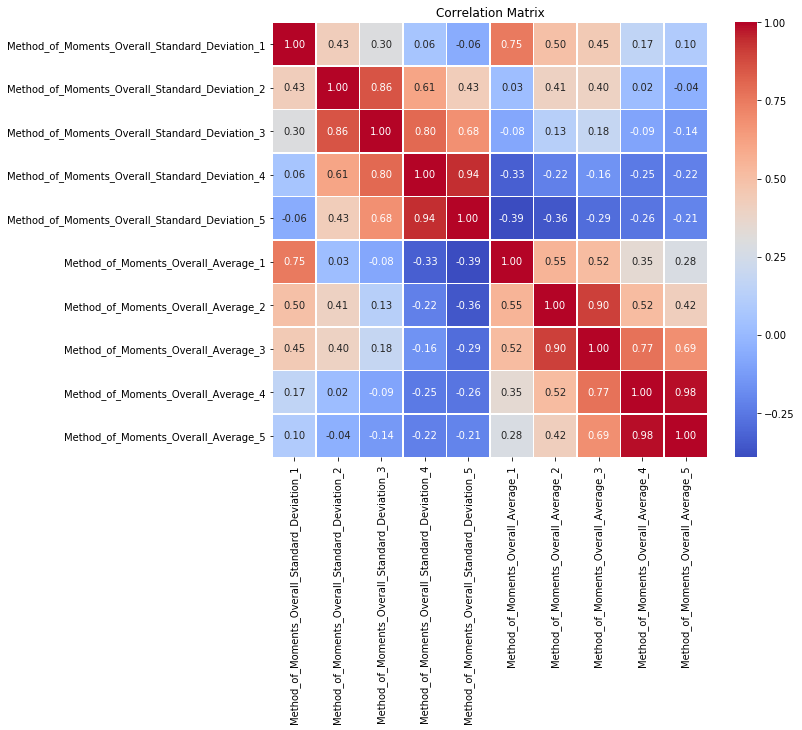

The chosen threshold is: 0.95.




The values are 1 if the correlations are higher than 0.95.


,index,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0
2,2,0,0,1,0,0,0,0,0,0,0
3,3,0,0,0,1,0,0,0,0,0,0
4,4,0,0,0,0,1,0,0,0,0,0
5,5,0,0,0,0,0,1,0,0,0,0
6,6,0,0,0,0,0,0,1,0,0,0
7,7,0,0,0,0,0,0,0,1,0,0
8,8,0,0,0,0,0,0,0,0,1,1
9,9,0,0,0,0,0,0,0,0,1,1


In [38]:

correlation_matrix = pd.DataFrame(correlations, columns=inputCols, index=inputCols)

# Plotting
plt.figure(figsize=(10, 8))  # Size of the figure
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm',
            cbar=True, square=True, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

threshold = 0.95
print(f'The chosen threshold is: {threshold}.')
print('\n')

print('\n')
print(f'The values are 1 if the correlations are higher than {threshold}.')
display(pd.DataFrame(correlations > threshold).astype(int).reset_index())


## (b) Load the MSD All Music Genre Dataset (MAGD).
## Visualize the distribution of genres for the songs that were matched.

In [14]:
# Loading the MAGD data

magd_genre_schema = StructType([
    StructField("track_id", StringType(), True),
    StructField("genre", StringType(), True)
])
magd_genre = spark.read.csv('hdfs:///data//msd/genre/msd-MAGD-genreAssignment.tsv',
                            schema = magd_genre_schema,
                            header = False,
                            sep = r"\t"
                            ).repartition(partitions)

magd_genre.printSchema()
magd_genre.show(5)

print(f'There are {magd_genre.count()} rows in magd_genre.')
print('\n')

root
 |-- track_id: string (nullable = true)
 |-- genre: string (nullable = true)

+------------------+----------+
|          track_id|     genre|
+------------------+----------+
|TRXOZJE128F4278282|  Pop_Rock|
|TRYEEUA128E078BCE9|  Pop_Rock|
|TRZAUBX128F92ED4D5|  Pop_Rock|
|TRXHIEF128F14654A0|Electronic|
|TRYIKQZ128F42B7B01|       Rap|
+------------------+----------+
only showing top 5 rows

There are 422714 rows in magd_genre.




In [15]:
#calculating the frequency
genre_group = magd_genre.groupBy(F.col('genre')).count().orderBy(F.desc("count"))
genre_group.show(21)

+--------------+------+
|         genre| count|
+--------------+------+
|      Pop_Rock|238786|
|    Electronic| 41075|
|           Rap| 20939|
|          Jazz| 17836|
|         Latin| 17590|
|           RnB| 14335|
| International| 14242|
|       Country| 11772|
|     Religious|  8814|
|        Reggae|  6946|
|         Blues|  6836|
|         Vocal|  6195|
|          Folk|  5865|
|       New Age|  4010|
| Comedy_Spoken|  2067|
|        Stage |  1614|
|Easy_Listening|  1545|
|   Avant_Garde|  1014|
|     Classical|   556|
|      Children|   477|
|       Holiday|   200|
+--------------+------+



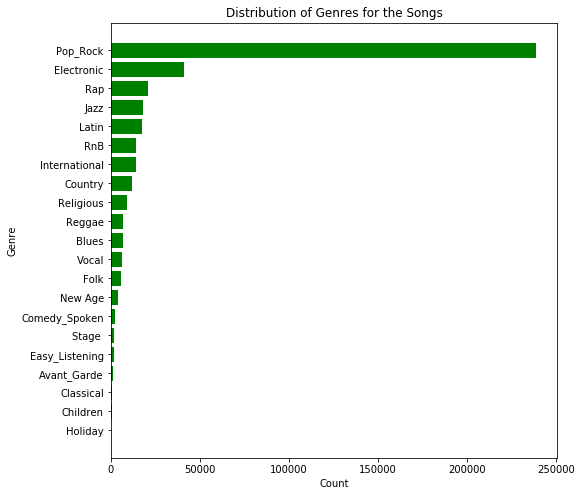

In [16]:
genre_group_df = genre_group.toPandas().sort_values('count', ascending=True)

# Create the plot
plt.figure(figsize=(8, 8))
plt.barh(genre_group_df['genre'], genre_group_df['count'], color='green')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title("Distribution of Genres for the Songs")

plt.show()

### (c) Merge the genres dataset and the audio features dataset so that every song has a label.

In [17]:
magd_genre.head(5)

[Row(track_id='TRNNLGF128F425EA77', genre='Pop_Rock'),
 Row(track_id='TRQHUSI128F14AD8BB', genre='Pop_Rock'),
 Row(track_id='TRSOQST12903CB26BD', genre='Pop_Rock'),
 Row(track_id='TRLDFFK128F933CDD6', genre='Rap'),
 Row(track_id='TRMDDGL128F93264CA', genre='Pop_Rock')]

In [18]:
data.head(5)

[Row(Method_of_Moments_Overall_Standard_Deviation_1=0.1396, Method_of_Moments_Overall_Standard_Deviation_2=12.72, Method_of_Moments_Overall_Standard_Deviation_3=689.9, Method_of_Moments_Overall_Standard_Deviation_4=44440.0, Method_of_Moments_Overall_Standard_Deviation_5=6443000.0, Method_of_Moments_Overall_Average_1=0.2932, Method_of_Moments_Overall_Average_2=26.54, Method_of_Moments_Overall_Average_3=1395.0, Method_of_Moments_Overall_Average_4=89460.0, Method_of_Moments_Overall_Average_5=11470000.0, MSD_TRACKID='TRRERBY128F933A995'),
 Row(Method_of_Moments_Overall_Standard_Deviation_1=0.156, Method_of_Moments_Overall_Standard_Deviation_2=16.94, Method_of_Moments_Overall_Standard_Deviation_3=762.2, Method_of_Moments_Overall_Standard_Deviation_4=49340.0, Method_of_Moments_Overall_Standard_Deviation_5=7240000.0, Method_of_Moments_Overall_Average_1=0.2474, Method_of_Moments_Overall_Average_2=28.56, Method_of_Moments_Overall_Average_3=1630.0, Method_of_Moments_Overall_Average_4=155900.0, M

In [19]:
#Merge the genres dataset 
merge_genre_features = magd_genre.join(data.withColumnRenamed('MSD_TRACKID', 'track_id'), 
                                       on='track_id',
                                       how='left')
merge_genre_features.show(5)
print(f'There are {merge_genre_features.count()} songs that have a label.')

+------------------+-------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+----------------------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+-----------------------------------+
|          track_id|        genre|Method_of_Moments_Overall_Standard_Deviation_1|Method_of_Moments_Overall_Standard_Deviation_2|Method_of_Moments_Overall_Standard_Deviation_3|Method_of_Moments_Overall_Standard_Deviation_4|Method_of_Moments_Overall_Standard_Deviation_5|Method_of_Moments_Overall_Average_1|Method_of_Moments_Overall_Average_2|Method_of_Moments_Overall_Average_3|Method_of_Moments_Overall_Average_4|Method_of_Moments_Overall_Average_5|
+------------------+-------------+----------------------------------------------+-------------------

### Which means every song has a label 

# Q2 
## First you will develop a binary classification model.
## (a) 
### Research and choose three classification algorithms from the spark.ml library. Justify your choice of algorithms, taking into account considerations such as explainability, interpretability, predictive accuracy, training speed, hyperparameter tuning, dimensionality, and issues with scaling. Based on the descriptive statistics from Q1 part (a), decide what processing you should apply to the audio features before using them to train each model.

Three Methods would be ...

 Since there are highly correlated columns, we need to drop one of the columns before starting the training. 

In [20]:
merge_genre_features_2 = merge_genre_features.drop(F.col("Method_of_Moments_Overall_Average_5"))

In [21]:
# Select
assembler = VectorAssembler(
    inputCols=[col for col in merge_genre_features_2.columns if col.startswith("Me")],
    outputCol="features"
).setHandleInvalid("skip") 
merge_genre_features_3 = assembler.transform(merge_genre_features_2)
merge_genre_features_3 = merge_genre_features_3.select(
    F.col('track_id') ,
    F.col('genre') ,
    F.col('features'),
)

merge_genre_features_3.show(10)

+------------------+-------------+--------------------+
|          track_id|        genre|            features|
+------------------+-------------+--------------------+
|TRAAABD128F429CF47|     Pop_Rock|[0.1308,9.587,459...|
|TRAAGTO128F1497E3C|     Pop_Rock|[0.1069,8.987,562...|
|TRAAHAU128F9313A3D|     Pop_Rock|[0.08485,9.031,44...|
|TRAAHZP12903CA25F4|          Rap|[0.1654,12.31,565...|
|TRAAICW128F1496C68|International|[0.1104,7.123,398...|
|TRAAMFF12903CE8107|     Pop_Rock|[0.1385,9.699,581...|
|TRAAMHG128F92ED7B2|International|[0.1799,10.52,551...|
|TRAAROH128F42604B0|   Electronic|[0.1192,16.4,737....|
|TRAAUIH128F4254C9D|       Reggae|[0.2276,15.73,639...|
|TRAAUQF12903CC4A4D|     Pop_Rock|[0.09249,16.31,60...|
+------------------+-------------+--------------------+
only showing top 10 rows



## (b) Convert the genre column into a binary column that represents if the song is ”Electronic” or some other genre.
## What is the class balance of the binary label?

In [24]:
merge_genre_features_4 = merge_genre_features_3.withColumn(
    'label',
    when(col('genre') == 'Electronic', 1).otherwise(0)
)

# Display the first 10 rows of the DataFrame
merge_genre_features_4.show(10)

+------------------+-------------+--------------------+-----+
|          track_id|        genre|            features|label|
+------------------+-------------+--------------------+-----+
|TRAAABD128F429CF47|     Pop_Rock|[0.1308,9.587,459...|    0|
|TRAAGTO128F1497E3C|     Pop_Rock|[0.1069,8.987,562...|    0|
|TRAAHAU128F9313A3D|     Pop_Rock|[0.08485,9.031,44...|    0|
|TRAAHZP12903CA25F4|          Rap|[0.1654,12.31,565...|    0|
|TRAAICW128F1496C68|International|[0.1104,7.123,398...|    0|
|TRAAMFF12903CE8107|     Pop_Rock|[0.1385,9.699,581...|    0|
|TRAAMHG128F92ED7B2|International|[0.1799,10.52,551...|    0|
|TRAAROH128F42604B0|   Electronic|[0.1192,16.4,737....|    1|
|TRAAUIH128F4254C9D|       Reggae|[0.2276,15.73,639...|    0|
|TRAAUQF12903CC4A4D|     Pop_Rock|[0.09249,16.31,60...|    0|
+------------------+-------------+--------------------+-----+
only showing top 10 rows



In [25]:
# Calculate 
total_count = merge_genre_features_4.count()

# Calculate label counts 
label_counts = merge_genre_features_4.groupBy('label').count()
label_counts = label_counts.withColumn('ratio', label_counts['count'] / total_count)

# Collect the label counts and ratios as a list
label_counts_list = label_counts.collect()

# Print
print("Dataset: merge_genre_features_4")
print(f"Total:   {total_count}")

# Print the label counts 
print("counts:")
for row in label_counts_list:
    print(f"   label   {row['label']}  {row['count']}  {row['ratio']:.6f}")


Dataset: merge_genre_features_4
Total:   420620
counts:
   label   1  40666  0.096681
   label   0  379954  0.903319


### (c) Split the dataset into training and test sets. You should use stratified random sampling to make sure the class balanced is preserved. You may also want to use a resampling method such as subsampling, oversampling, or observation weighting. Justify your overall
### approach and your choice of resampling method.

## stratified random sampling

In [24]:
temp = (
    merge_genre_features_4
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  # random number between 0 and 1
    .withColumn(
        "row",
        F.row_number()  # row number in each class partition (start at 0, 1, ... for positive and separately for negative)
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

training = temp.where(
    ((F.col("label") == 0) & (F.col("row") < 379954 * 0.8 )) |  # nP_actual = 379954 
    ((F.col("label") == 1) & (F.col("row") < 40666    * 0.8))    # nN_actual = 40666
)
training.cache()

test = temp.join(training, on="id", how="left_anti")
test.cache()

training = training.drop("id", "random", "row")
test = test.drop("id", "random", "row")

print_class_balance(merge_genre_features_4, "data")
print_class_balance(training, "training")
print_class_balance(test, "test")

dataset: data
total:   420620
counts:
   label   count     ratio
0      1   40666  0.096681
1      0  379954  0.903319

dataset: training
total:   336495
counts:
   label   count     ratio
0      1   32532  0.096679
1      0  303963  0.903321

dataset: test
total:   84125
counts:
   label  count     ratio
0      1   8134  0.096689
1      0  75991  0.903311



In [25]:
# Ensure datasets are cached

merge_genre_features_4.cache()
training.cache()
test.cache()

DataFrame[track_id: string, label: int, features: vector]

## Logistic Regression

In [26]:
from pyspark.ml.classification import LogisticRegression

In [27]:
# No sampling

print_class_balance(training, "training")

lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(training)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred)

dataset: training
total:   336495
counts:
   label   count     ratio
0      1   32532  0.096679
1      0  303963  0.903321

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        387
nN:        83738

TP         184
FP         203
FN         7950
TN         75788

precision: 0.47545220
recall:    0.02262110
accuracy:  0.90308470

auroc:     0.75487709



In [28]:
# Downsampling

training_downsampled = (
    training
    .withColumn("random", F.rand())
    .where((F.col("label") != 0) | ((F.col("label") == 0) & (F.col("random") < 2 * (40666 / 379954))))
)
training_downsampled.cache()

print_class_balance(training_downsampled, "training (downsampled)")

lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(training_downsampled)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred)

dataset: training (downsampled)
total:   97339
counts:
   label  count     ratio
0      1  32532  0.334213
1      0  64807  0.665787

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        11623
nN:        72502

TP         3410
FP         8213
FN         4724
TN         67778

precision: 0.29338381
recall:    0.41922793
accuracy:  0.84621694

auroc:     0.75528176



In [29]:
# Upsampling via poisson random sampling

counts = {label: count for label, count in training.groupBy("label").count().collect()}
count_lower_bound = 50000
count_upper_bound = 175000

def random_resample(x, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [x] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if np.random.rand() < count_upper_bound / count: # randomly downsample to count_upper_bound
            return [x]
        else:
            return []

    return [x]  # do nothing

random_resample_udf = F.udf(lambda x: random_resample(x, counts, count_lower_bound, count_upper_bound), ArrayType(IntegerType()))
training_resampled = (
    training
    .withColumn("sample", random_resample_udf(F.col("label")))
    .select(
        F.col("track_id"),
        F.col("label"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")
    )
    .drop("sample")
)

print_class_balance(training_resampled, "training (resampled)")

lr = LogisticRegression(featuresCol='features', labelCol='label')
lr_model = lr.fit(training_resampled)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred)

dataset: training (resampled)
total:   150126
counts:
   label   count     ratio
0      1   49669  0.330849
1      0  100279  0.667966

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        11343
nN:        72782

TP         3377
FP         7966
FN         4757
TN         68025

precision: 0.29771665
recall:    0.41517089
accuracy:  0.84876077

auroc:     0.75539952



In [158]:
# Observation reweighting

training_weighted = training.withColumn("weight", F.when(F.col("label") == 0, 0.4).when(F.col("label") == 1, 4.0).otherwise(1.0))

weights = (
    training_weighted
    .groupBy("label")
    .agg(
        F.collect_set(F.col("weight")).alias("weights")
    )
    .toPandas()
)
print(weights)

lr = LogisticRegression(featuresCol='features', labelCol='label', weightCol="weight")
lr_model = lr.fit(training_weighted)
pred = lr_model.transform(test)
pred.cache()

print_metrics(pred)

   label weights
0      1   [4.0]
1      0   [0.4]
metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        31641
nN:        52484

TP         5869
FP         25772
FN         2265
TN         50219

precision: 0.18548718
recall:    0.72153922
accuracy:  0.66672214

auroc:     0.75493481



## Gradient-Boosted Tree Classifier

In [31]:
from pyspark.ml.classification import GBTClassifier

In [32]:
# No sampling

print_class_balance(training, "training")

GBT = GBTClassifier(featuresCol='features', labelCol='label')
GBT_model = GBT.fit(training)
pred = GBT_model.transform(test)
pred.cache()

print_metrics(pred)

dataset: training
total:   336495
counts:
   label   count     ratio
0      1   32532  0.096679
1      0  303963  0.903321

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        1244
nN:        82881

TP         770
FP         474
FN         7364
TN         75517

precision: 0.61897106
recall:    0.09466437
accuracy:  0.90682912

auroc:     0.79940700



In [33]:
# Downsampling

training_downsampled = (
    training
    .withColumn("random", F.rand())
    .where((F.col("label") != 0) | ((F.col("label") == 0) & (F.col("random") < 2 * (40666 / 379954))))
)
training_downsampled.cache()

print_class_balance(training_downsampled, "training (downsampled)")

GBT = GBTClassifier(featuresCol='features', labelCol='label')
GBT_model = GBT.fit(training_downsampled)
pred = GBT_model.transform(test)
pred.cache()

print_metrics(pred)

dataset: training (downsampled)
total:   97603
counts:
   label  count     ratio
0      1  32532  0.333309
1      0  65071  0.666691

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        11988
nN:        72137

TP         3969
FP         8019
FN         4165
TN         67972

precision: 0.33108108
recall:    0.48795181
accuracy:  0.85516790

auroc:     0.80233400



In [34]:
# Upsampling via poisson random sampling

counts = {label: count for label, count in training.groupBy("label").count().collect()}
count_lower_bound = 50000
count_upper_bound = 175000

def random_resample(x, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [x] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if np.random.rand() < count_upper_bound / count: # randomly downsample to count_upper_bound
            return [x]
        else:
            return []

    return [x]  # do nothing

random_resample_udf = F.udf(lambda x: random_resample(x, counts, count_lower_bound, count_upper_bound), ArrayType(IntegerType()))
training_resampled = (
    training
    .withColumn("sample", random_resample_udf(F.col("label")))
    .select(
        F.col("track_id"),
        F.col("label"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")
    )
    .drop("sample")
)

print_class_balance(training_resampled, "training (resampled)")

GBT = GBTClassifier(featuresCol='features', labelCol='label')
GBT_model = GBT.fit(training_resampled)
pred = GBT_model.transform(test)
pred.cache()

print_metrics(pred)

dataset: training (resampled)
total:   150126
counts:
   label   count     ratio
0      1   49669  0.330849
1      0  100279  0.667966

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        11986
nN:        72139

TP         3980
FP         8006
FN         4154
TN         67985

precision: 0.33205406
recall:    0.48930416
accuracy:  0.85545319

auroc:     0.80403704



In [159]:
# Observation reweighting

training_weighted = training.withColumn("weight", F.when(F.col("label") == 0, 0.4).when(F.col("label") == 1, 4.0).otherwise(1.0))

weights = (
    training_weighted
    .groupBy("label")
    .agg(
        F.collect_set(F.col("weight")).alias("weights")
    )
    .toPandas()
)
print(weights)

GBT = GBTClassifier(featuresCol='features', labelCol='label', weightCol="weight")
GBT_model = GBT.fit(training_weighted)
pred = GBT_model.transform(test)
pred.cache()

print_metrics(pred)

   label weights
0      1   [4.0]
1      0   [0.4]
metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        26123
nN:        58002

TP         5882
FP         20241
FN         2252
TN         55750

precision: 0.22516556
recall:    0.72313745
accuracy:  0.73262407

auroc:     0.80410242



## Support Vector Machine (SVM)

In [36]:
from pyspark.ml.classification import LinearSVC

In [160]:
# No sampling

print_class_balance(training, "training")

SVC = LinearSVC(featuresCol='features', labelCol='label')
SVC_model = SVC.fit(training)
pred = SVC_model.transform(test)
pred.cache()

print_metrics(pred)

dataset: training
total:   336495
counts:
   label   count     ratio
0      1   32532  0.096679
1      0  303963  0.903321

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        0
nN:        84125

TP         0
FP         0
FN         8134
TN         75991

precision: 0.00000000
recall:    0.00000000
accuracy:  0.90331055

auroc:     0.70672630



In [38]:
# Downsampling

training_downsampled = (
    training
    .withColumn("random", F.rand())
    .where((F.col("label") != 0) | ((F.col("label") == 0) & (F.col("random") < 2 * (40666 / 379954))))
)
training_downsampled.cache()

print_class_balance(training_downsampled, "training (downsampled)")

SVC = LinearSVC(featuresCol='features', labelCol='label')
SVC_model = SVC.fit(training_downsampled)
pred = SVC_model.transform(test)
pred.cache()

print_metrics(pred)

dataset: training (downsampled)
total:   97816
counts:
   label  count     ratio
0      1  32532  0.332584
1      0  65284  0.667416

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        635
nN:        83490

TP         282
FP         353
FN         7852
TN         75638

precision: 0.44409449
recall:    0.03466929
accuracy:  0.90246657

auroc:     0.71787506



In [39]:
# Upsampling via poisson random sampling

counts = {label: count for label, count in training.groupBy("label").count().collect()}
count_lower_bound = 50000
count_upper_bound = 175000

def random_resample(x, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [x] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if np.random.rand() < count_upper_bound / count: # randomly downsample to count_upper_bound
            return [x]
        else:
            return []

    return [x]  # do nothing

random_resample_udf = F.udf(lambda x: random_resample(x, counts, count_lower_bound, count_upper_bound), ArrayType(IntegerType()))
training_resampled = (
    training
    .withColumn("sample", random_resample_udf(F.col("label")))
    .select(
        F.col("track_id"),
        F.col("label"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")
    )
    .drop("sample")
)

print_class_balance(training_resampled, "training (resampled)")

SVC = LinearSVC(featuresCol='features', labelCol='label')
SVC_model = SVC.fit(training_resampled)
pred = SVC_model.transform(test)
pred.cache()

print_metrics(pred)

dataset: training (resampled)
total:   150126
counts:
   label   count     ratio
0      1   49847  0.332034
1      0  100254  0.667799

metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        1402
nN:        82723

TP         618
FP         784
FN         7516
TN         75207

precision: 0.44079886
recall:    0.07597738
accuracy:  0.90133730

auroc:     0.71395393



In [161]:
# Observation reweighting

training_weighted = training.withColumn("weight", F.when(F.col("label") == 0, 0.4).when(F.col("label") == 1, 4.0).otherwise(1.0))

weights = (
    training_weighted
    .groupBy("label")
    .agg(
        F.collect_set(F.col("weight")).alias("weights")
    )
    .toPandas()
)
print(weights)

SVC = LinearSVC(featuresCol='features', labelCol='label', weightCol="weight")
SVC_model = SVC.fit(training_weighted)
pred = SVC_model.transform(test)
pred.cache()

print_metrics(pred)

   label weights
0      1   [4.0]
1      0   [0.4]
metrics for custom threshold

threshold: 0.5

total:     84125

nP actual: 8134
nN actual: 75991

nP:        32849
nN:        51276

TP         5713
FP         27136
FN         2421
TN         48855

precision: 0.17391701
recall:    0.70236046
accuracy:  0.64865379

auroc:     0.72522760



(f) Discuss the relative performance of each model and of the classification algorithms overall,
taking into account the performance metrics that you computed in part (e).
How does the class balance of the binary label affect the performance of the algorithms?

# Q3 Discuss

# Q4 - A Disucss

### Q4 - B Convert the genre column into an integer index that encodes each genre consistently. Find a way to do this that requires the least amount of work by hand

In [41]:
from pyspark.ml.feature import StringIndexer


stringIndexer = StringIndexer(inputCol="genre", outputCol="label", stringOrderType="frequencyDesc")
model = stringIndexer.fit(merge_genre_features_3)
feature_genre_encoded = model.transform(merge_genre_features_3)

In [42]:
feature_genre_encoded_freq = feature_genre_encoded.groupBy("label").count().sort("label")
show_as_html(feature_genre_encoded_freq,50)

,label,count
0,0.0,237649
1,1.0,40666
2,2.0,20899
3,3.0,17775
4,4.0,17504
5,5.0,14314
6,6.0,14194
7,7.0,11691
8,8.0,8780
9,9.0,6931


## (c) 
### Split your dataset into training and test sets, train the classification algorithm that you chose in part (b), and compute a range of performance metrics that are relevant to multiclass classification. Make sure you take into account the class balance in your comments.How has the performance of your model been affected by the inclusion of multiple genres?

In [43]:
feature_genre_metadata = feature_genre_encoded.select(F.col('label'), F.col('genre')).distinct()\
.orderBy('label')
feature_genre_metadata_2 = feature_genre_metadata.join(feature_genre_encoded_freq, on='label').orderBy('label')
feature_genre_metadata_3 = feature_genre_metadata_2.withColumn('percent',\
                                                               F.format_number( F.col('count')/feature_genre_encoded.count(),3) )
feature_genre_metadata_3.show(50)

+-----+--------------+------+-------+
|label|         genre| count|percent|
+-----+--------------+------+-------+
|  0.0|      Pop_Rock|237649|  0.565|
|  1.0|    Electronic| 40666|  0.097|
|  2.0|           Rap| 20899|  0.050|
|  3.0|          Jazz| 17775|  0.042|
|  4.0|         Latin| 17504|  0.042|
|  5.0|           RnB| 14314|  0.034|
|  6.0| International| 14194|  0.034|
|  7.0|       Country| 11691|  0.028|
|  8.0|     Religious|  8780|  0.021|
|  9.0|        Reggae|  6931|  0.016|
| 10.0|         Blues|  6801|  0.016|
| 11.0|         Vocal|  6182|  0.015|
| 12.0|          Folk|  5789|  0.014|
| 13.0|       New Age|  4000|  0.010|
| 14.0| Comedy_Spoken|  2067|  0.005|
| 15.0|        Stage |  1613|  0.004|
| 16.0|Easy_Listening|  1535|  0.004|
| 17.0|   Avant_Garde|  1012|  0.002|
| 18.0|     Classical|   555|  0.001|
| 19.0|      Children|   463|  0.001|
| 20.0|       Holiday|   200|  0.000|
+-----+--------------+------+-------+



### Splitting data into training and test 

In [44]:
temp_multi = (
    feature_genre_encoded
    .withColumn("id", F.monotonically_increasing_id())
    .withColumn("random", F.rand())  
    .withColumn(
        "row",
        F.row_number()  
        .over(
            Window
            .partitionBy("label")
            .orderBy("random")
        )
    )
)

In [45]:
training_multi = temp_multi.where(
    ((F.col("label") == 0) & (F.col("row") < 237649 * 0.8)) |
    ((F.col("label") == 1) & (F.col("row") < 40666 * 0.8)) |
    ((F.col("label") == 2) & (F.col("row") < 20899 * 0.8)) |
    ((F.col("label") == 3) & (F.col("row") < 17775 * 0.8)) |
    ((F.col("label") == 4) & (F.col("row") < 17504 * 0.8)) |
    ((F.col("label") == 5) & (F.col("row") < 14314 * 0.8)) |
    ((F.col("label") == 6) & (F.col("row") < 14194 * 0.8)) |
    ((F.col("label") == 7) & (F.col("row") < 11691 * 0.8)) |
    ((F.col("label") == 8) & (F.col("row") < 8780 * 0.8)) |
    ((F.col("label") == 9) & (F.col("row") < 6931 * 0.8)) |
    ((F.col("label") == 10) & (F.col("row") < 6801 * 0.8)) |
    ((F.col("label") == 11) & (F.col("row") < 6182 * 0.8)) |
    ((F.col("label") == 12) & (F.col("row") < 5789 * 0.8)) |
    ((F.col("label") == 13) & (F.col("row") < 4000 * 0.8)) |
    ((F.col("label") == 14) & (F.col("row") < 2067 * 0.8)) |
    ((F.col("label") == 15) & (F.col("row") < 1613 * 0.8)) |
    ((F.col("label") == 16) & (F.col("row") < 1535 * 0.8)) |
    ((F.col("label") == 17) & (F.col("row") < 1012 * 0.8)) |
    ((F.col("label") == 18) & (F.col("row") < 555* 0.8)) |
    ((F.col("label") == 19) & (F.col("row") < 463 * 0.8)) |  
    ((F.col("label") == 20) & (F.col("row") < 200* 0.8))
)
training_multi.cache()
test_multi = temp_multi.join(training_multi, on="id", how="left_anti")
test_multi.cache() 

training_multi = training_multi.drop("id", "random", "row")
test_multi = test_multi.drop("id", "random", "row")

print_class_balance(feature_genre_encoded, "feature_genre_encoded")
print_class_balance(training_multi, "training_multi")
print_class_balance(test_multi, "test_multi")

dataset: feature_genre_encoded
total:   420620
counts:
    label   count     ratio
0    13.0    4000  0.009510
1     6.0   14194  0.033745
2    16.0    1535  0.003649
3    19.0     463  0.001101
4     7.0   11691  0.027795
5     4.0   17504  0.041615
6    20.0     200  0.000475
7     9.0    6931  0.016478
8    18.0     555  0.001319
9     3.0   17775  0.042259
10   11.0    6182  0.014697
11   12.0    5789  0.013763
12    1.0   40666  0.096681
13   10.0    6801  0.016169
14    5.0   14314  0.034031
15   17.0    1012  0.002406
16    8.0    8780  0.020874
17   14.0    2067  0.004914
18    0.0  237649  0.564997
19    2.0   20899  0.049686
20   15.0    1613  0.003835

dataset: training_multi
total:   336483
counts:
    label   count     ratio
0     6.0   11355  0.033746
1    13.0    3199  0.009507
2    16.0    1227  0.003647
3    19.0     370  0.001100
4     7.0    9352  0.027793
5     4.0   14003  0.041616
6    20.0     159  0.000473
7     9.0    5544  0.016476
8    18.0     443  0.001317


### Training the logistic regression model for this multiclass classification

In [46]:

# Define the logistic regression classifier
mlr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=20, elasticNetParam=0, fitIntercept=True)

# Wrap the classifier in the OneVsRest framework
ovr = OneVsRest(classifier=mlr)
ovrModel = ovr.fit(training_multi)
predictions = ovrModel.transform(test_multi)

# Instantiate the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Evaluate accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"Accuracy = {accuracy}")

# Evaluate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"})
print(f"Precision = {precision}")

# Evaluate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})
print(f"Recall = {recall}")

# Evaluate F1 Score
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"F1 Score = {f1}")

# Calculate Test Error
test_error = 1.0 - accuracy
print(f"Test Error = {test_error}")


Accuracy = 0.5711280411709474
Precision = 0.5808173394689913
Recall = 0.9798863875447086
F1 Score = 0.43927327564085966
Test Error = 0.4288719588290526


### Extracting the class wise metric values

In [47]:

# Convert DataFrame to an RDD
predictionAndLabels = predictions.select("prediction", "label").rdd

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Get labels from data
labels = predictionAndLabels.map(lambda x: x[1]).distinct().collect()

# Prepare data for DataFrame
data = []
for label in sorted(labels):
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1 = metrics.fMeasure(label)
    data.append((label, precision, recall, f1))

# Define DataFrame schema
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType

schema = StructType([
    StructField("Class", FloatType(), True),
    StructField("Precision", FloatType(), True),
    StructField("Recall", FloatType(), True),
    StructField("F1 Score", FloatType(), True)
])

# Create DataFrame
metrics_df = spark.createDataFrame(data, schema)


# Show DataFrame
metrics_df.show()



+-----+----------+------------+-----------+
|Class| Precision|      Recall|   F1 Score|
+-----+----------+------------+-----------+
|  0.0|0.58081734|   0.9798864| 0.72933125|
|  1.0|0.41947928|  0.10695845| 0.17045455|
|  2.0|0.33976352|  0.13062201| 0.18869881|
|  3.0|0.16346154|0.0047806525|0.009289618|
|  4.0|       0.0|         0.0|        0.0|
|  5.0|0.23423423| 0.009081383|0.017484868|
|  6.0|       0.0|         0.0|        0.0|
|  7.0|       0.0|         0.0|        0.0|
|  8.0|       0.0|         0.0|        0.0|
|  9.0|       0.0|         0.0|        0.0|
| 10.0|       0.0|         0.0|        0.0|
| 11.0|       0.0|         0.0|        0.0|
| 12.0|       0.0|         0.0|        0.0|
| 13.0|       0.0|         0.0|        0.0|
| 14.0|       0.4| 0.048309177|  0.0862069|
| 15.0|       0.0|         0.0|        0.0|
| 16.0|       0.0|         0.0|        0.0|
| 17.0|       0.0|         0.0|        0.0|
| 18.0|       0.0|         0.0|        0.0|
| 19.0|       0.0|         0.0| 

In [48]:
feature_genre_metadata_3.show(21)

+-----+--------------+------+-------+
|label|         genre| count|percent|
+-----+--------------+------+-------+
|  0.0|      Pop_Rock|237649|  0.565|
|  1.0|    Electronic| 40666|  0.097|
|  2.0|           Rap| 20899|  0.050|
|  3.0|          Jazz| 17775|  0.042|
|  4.0|         Latin| 17504|  0.042|
|  5.0|           RnB| 14314|  0.034|
|  6.0| International| 14194|  0.034|
|  7.0|       Country| 11691|  0.028|
|  8.0|     Religious|  8780|  0.021|
|  9.0|        Reggae|  6931|  0.016|
| 10.0|         Blues|  6801|  0.016|
| 11.0|         Vocal|  6182|  0.015|
| 12.0|          Folk|  5789|  0.014|
| 13.0|       New Age|  4000|  0.010|
| 14.0| Comedy_Spoken|  2067|  0.005|
| 15.0|        Stage |  1613|  0.004|
| 16.0|Easy_Listening|  1535|  0.004|
| 17.0|   Avant_Garde|  1012|  0.002|
| 18.0|     Classical|   555|  0.001|
| 19.0|      Children|   463|  0.001|
| 20.0|       Holiday|   200|  0.000|
+-----+--------------+------+-------+



In [49]:
from pyspark.sql.functions import col, desc, count

In [50]:
Multiclass_df = feature_genre_metadata_3.join(metrics_df.withColumnRenamed("Class","label"), 
                                              on="label",
                                              how = "left").orderBy(desc("count"))
Multiclass_df.show(21)

+-----+--------------+------+-------+----------+------------+-----------+
|label|         genre| count|percent| Precision|      Recall|   F1 Score|
+-----+--------------+------+-------+----------+------------+-----------+
|  0.0|      Pop_Rock|237649|  0.565|0.58081734|   0.9798864| 0.72933125|
|  1.0|    Electronic| 40666|  0.097|0.41947928|  0.10695845| 0.17045455|
|  2.0|           Rap| 20899|  0.050|0.33976352|  0.13062201| 0.18869881|
|  3.0|          Jazz| 17775|  0.042|0.16346154|0.0047806525|0.009289618|
|  4.0|         Latin| 17504|  0.042|       0.0|         0.0|        0.0|
|  5.0|           RnB| 14314|  0.034|0.23423423| 0.009081383|0.017484868|
|  6.0| International| 14194|  0.034|       0.0|         0.0|        0.0|
|  7.0|       Country| 11691|  0.028|       0.0|         0.0|        0.0|
|  8.0|     Religious|  8780|  0.021|       0.0|         0.0|        0.0|
|  9.0|        Reggae|  6931|  0.016|       0.0|         0.0|        0.0|
| 10.0|         Blues|  6801|  0.016| 

In [51]:
Multiclass_pd = Multiclass_df.toPandas()
Multiclass_pd.head(5)

### Plotting the side by side total count and the metric values in specific genres

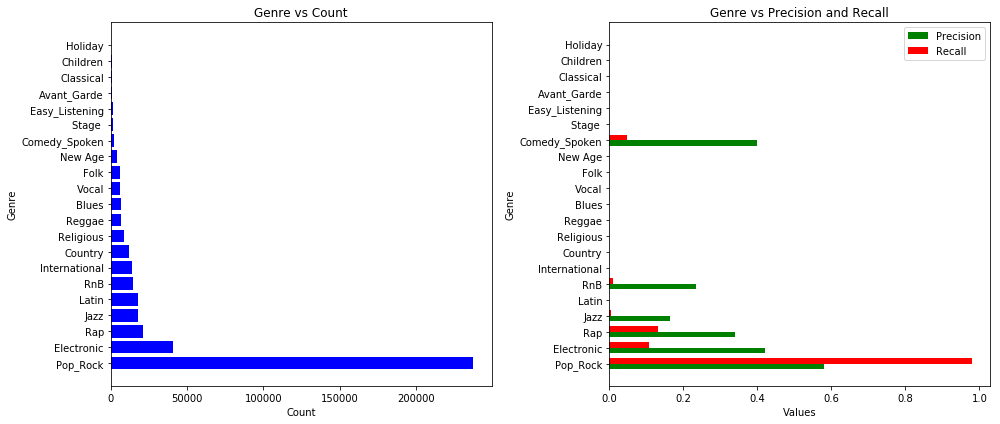

In [53]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plotting genre vs count
axes[0].barh(Multiclass_pd['genre'], Multiclass_pd['count'], color='blue')
axes[0].set_title('Genre vs Count')
axes[0].set_xlabel('Count')
axes[0].set_ylabel('Genre')

# Plotting genre vs precision and recall in the same plot
bar_width = 0.35  # width of the bars
genres = Multiclass_pd['genre']
y_positions = range(len(genres))  

# Create bars for precision and recall
axes[1].barh([y - bar_width/2 for y in y_positions], Multiclass_pd['Precision'], height=bar_width, label='Precision', color='green')
axes[1].barh([y + bar_width/2 for y in y_positions], Multiclass_pd['Recall'], height=bar_width, label='Recall', color='red')

axes[1].set_title('Genre vs Precision and Recall')
axes[1].set_xlabel('Values')
axes[1].set_ylabel('Genre')
axes[1].set_yticks(y_positions)  
axes[1].set_yticklabels(genres)  
axes[1].legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()



In [72]:
print_class_balance(training_multi, "training multi")

dataset: training multi
total:   336483
counts:
    label   count     ratio
0     6.0   11355  0.033746
1    13.0    3199  0.009507
2    16.0    1227  0.003647
3    19.0     370  0.001100
4     7.0    9352  0.027793
5     4.0   14003  0.041616
6    20.0     159  0.000473
7     9.0    5544  0.016476
8    18.0     443  0.001317
9     3.0   14219  0.042258
10   11.0    4945  0.014696
11   12.0    4631  0.013763
12    1.0   32532  0.096682
13   10.0    5440  0.016167
14    5.0   11451  0.034031
15   17.0     809  0.002404
16    8.0    7023  0.020872
17   14.0    1653  0.004913
18    0.0  190119  0.565018
19    2.0   16719  0.049688
20   15.0    1290  0.003834



### downsampling the common genres

In [127]:
training_downsampled = (
    training_multi
    .withColumn("random", F.rand())
    .where((F.col("label") != 0) | ((F.col("label") == 0) & (F.col("random") < 2 * (50000 / 379954))))
    .where((F.col("label") != 1) | ((F.col("label") == 1) & (F.col("random") < 2 * (100000 / 379954))))
    .where((F.col("label") != 2) | ((F.col("label") == 2) & (F.col("random") < 2 * (200000/ 379954))))

)
training_downsampled.cache()

print_class_balance(training_downsampled, "training (downsampled)")

dataset: training (downsampled)
total:   180985
counts:
    label  count     ratio
0     6.0  11355  0.062740
1    13.0   3199  0.017675
2    16.0   1227  0.006780
3    19.0    370  0.002044
4     7.0   9352  0.051673
5     4.0  14003  0.077371
6    20.0    159  0.000879
7     9.0   5544  0.030632
8    18.0    443  0.002448
9     3.0  14219  0.078565
10   11.0   4945  0.027323
11   12.0   4631  0.025588
12    1.0  17210  0.095091
13   10.0   5440  0.030058
14    5.0  11451  0.063270
15   17.0    809  0.004470
16    8.0   7023  0.038804
17   14.0   1653  0.009133
18    0.0  49943  0.275951
19    2.0  16719  0.092378
20   15.0   1290  0.007128



### upsampling the rare genres

In [128]:
# Upsampling via poisson random sampling

counts = {label: count for label, count in training_downsampled.groupBy("label").count().collect()}
count_lower_bound = 3000
count_upper_bound = 175000

def random_resample(x, counts, count_lower_bound, count_upper_bound):

    count = counts[x]

    if count < count_lower_bound:
        return [x] * int(1 + np.random.poisson((count_lower_bound - count) / count))  # randomly upsample to count_lower_bound

    if count > count_upper_bound:
        if np.random.rand() < count_upper_bound / count: # randomly downsample to count_upper_bound
            return [x]
        else:
            return []

    return [x]  # do nothing

random_resample_udf = F.udf(lambda x: random_resample(x, counts, count_lower_bound, count_upper_bound), ArrayType(IntegerType()))
training_resampled = (
    training_downsampled
    .withColumn("sample", random_resample_udf(F.col("label")))
    .select(
        F.col("track_id"),
        F.col("label"),
        F.col("features"),
        F.explode(F.col("sample")).alias("sample")
    )
    .drop("sample")
)

print_class_balance(training_resampled, "training (resampled)")


dataset: training (resampled)
total:   196144
counts:
    label  count     ratio
0     6.0  11355  0.057891
1    13.0   3199  0.016309
2    16.0   3066  0.015631
3    19.0   3028  0.015438
4     7.0   9352  0.047679
5     4.0  14003  0.071391
6    20.0   3019  0.015392
7     9.0   5544  0.028265
8    18.0   2975  0.015167
9     3.0  14219  0.072493
10   11.0   4945  0.025211
11   12.0   4631  0.023610
12    1.0  17210  0.087742
13   10.0   5440  0.027735
14    5.0  11451  0.058381
15   17.0   3015  0.015371
16    8.0   7023  0.035805
17   14.0   3041  0.015504
18    0.0  49943  0.254624
19    2.0  16719  0.085238
20   15.0   3008  0.015336



## Training the model again with the resampled training data

In [129]:

# Define the logistic regression classifier
mlr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=20, elasticNetParam=0, fitIntercept=True)

# Wrap the classifier in the OneVsRest framework
ovr = OneVsRest(classifier=mlr)
ovrModel = ovr.fit(training_resampled)
predictions = ovrModel.transform(test_multi)

# Instantiate the evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

# Evaluate accuracy
accuracy = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
print(f"Accuracy = {accuracy}")

# Evaluate precision
precision = evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel"})
print(f"Precision = {precision}")

# Evaluate recall
recall = evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel"})
print(f"Recall = {recall}")

# Evaluate F1 Score
f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
print(f"F1 Score = {f1}")

# Calculate Test Error
test_error = 1.0 - accuracy
print(f"Test Error = {test_error}")


Accuracy = 0.5420920641334965
Precision = 0.6432416173257766
Recall = 0.8548495686934567
F1 Score = 0.4685901818492875
Test Error = 0.45790793586650347


### Extracting the class wise metric values

In [130]:
# Convert DataFrame to an RDD
predictionAndLabels = predictions.select("prediction", "label").rdd

# Instantiate metrics object
metrics = MulticlassMetrics(predictionAndLabels)

# Get labels from data
labels = predictionAndLabels.map(lambda x: x[1]).distinct().collect()

# Prepare data for DataFrame
data = []
for label in sorted(labels):
    precision = metrics.precision(label)
    recall = metrics.recall(label)
    f1 = metrics.fMeasure(label)
    data.append((label, precision, recall, f1))

# Define DataFrame schema
from pyspark.sql.types import StructType, StructField, FloatType, IntegerType

schema = StructType([
    StructField("Class", FloatType(), True),
    StructField("Precision", FloatType(), True),
    StructField("Recall", FloatType(), True),
    StructField("F1 Score", FloatType(), True)
])

# Create DataFrame
metrics_resampled_df = spark.createDataFrame(data, schema)


# Show DataFrame
metrics_resampled_df.show()

# Calculate overall accuracy and test error
accuracy = metrics.accuracy
print(f"Accuracy = {accuracy}")
test_error = 1.0 - accuracy
print(f"Test Error = {test_error}")

+-----+-----------+------------+------------+
|Class|  Precision|      Recall|    F1 Score|
+-----+-----------+------------+------------+
|  0.0| 0.64324164|   0.8548496|   0.7341006|
|  1.0|  0.3259943|   0.1692894|  0.22285159|
|  2.0| 0.25229016|   0.4875598|  0.33251753|
|  3.0| 0.19301713|   0.3295838|  0.24345659|
|  4.0| 0.05882353|2.8563268E-4|5.6850485E-4|
|  5.0| 0.15091576|   0.0719525|   0.0974456|
|  6.0|        1.0| 3.522367E-4| 7.042253E-4|
|  7.0|        0.0|         0.0|         0.0|
|  8.0|        0.0|         0.0|         0.0|
|  9.0|        0.0|         0.0|         0.0|
| 10.0|  0.1521739| 0.005143277|0.0099502485|
| 11.0| 0.14705883| 0.008084075|  0.01532567|
| 12.0|        1.0|8.6355786E-4|0.0017256256|
| 13.0|0.051948052|0.0049937577| 0.009111618|
| 14.0| 0.22445561|   0.3236715|   0.2650841|
| 15.0| 0.08712121| 0.071207434| 0.078364566|
| 16.0|        0.0|         0.0|         0.0|
| 17.0| 0.05263158|0.0049261083| 0.009009009|
| 18.0| 0.03539823| 0.035714287| 0

In [131]:
# Joining the genre dataframe

Multiclass_resampled_df = feature_genre_metadata_3.join(metrics_resampled_df.withColumnRenamed("Class","label"), 
                                              on="label",
                                              how = "left").orderBy(desc("count"))
Multiclass_resampled_df .show(21)

+-----+--------------+------+-------+-----------+------------+------------+
|label|         genre| count|percent|  Precision|      Recall|    F1 Score|
+-----+--------------+------+-------+-----------+------------+------------+
|  0.0|      Pop_Rock|237649|  0.565| 0.64324164|   0.8548496|   0.7341006|
|  1.0|    Electronic| 40666|  0.097|  0.3259943|   0.1692894|  0.22285159|
|  2.0|           Rap| 20899|  0.050| 0.25229016|   0.4875598|  0.33251753|
|  3.0|          Jazz| 17775|  0.042| 0.19301713|   0.3295838|  0.24345659|
|  4.0|         Latin| 17504|  0.042| 0.05882353|2.8563268E-4|5.6850485E-4|
|  5.0|           RnB| 14314|  0.034| 0.15091576|   0.0719525|   0.0974456|
|  6.0| International| 14194|  0.034|        1.0| 3.522367E-4| 7.042253E-4|
|  7.0|       Country| 11691|  0.028|        0.0|         0.0|         0.0|
|  8.0|     Religious|  8780|  0.021|        0.0|         0.0|         0.0|
|  9.0|        Reggae|  6931|  0.016|        0.0|         0.0|         0.0|
| 10.0|     

In [132]:
Multiclass_resampled_pd = Multiclass_resampled_df.toPandas()
Multiclass_resampled_pd.head(5)

,label,genre,count,percent,Precision,Recall,F1 Score
0,0.0,Pop_Rock,237649,0.565,0.643242,0.854850,0.734101
1,1.0,Electronic,40666,0.097,0.325994,0.169289,0.222852
2,2.0,Rap,20899,0.050,0.252290,0.487560,0.332518
3,3.0,Jazz,17775,0.042,0.193017,0.329584,0.243457
4,4.0,Latin,17504,0.042,0.058824,0.000286,0.000569


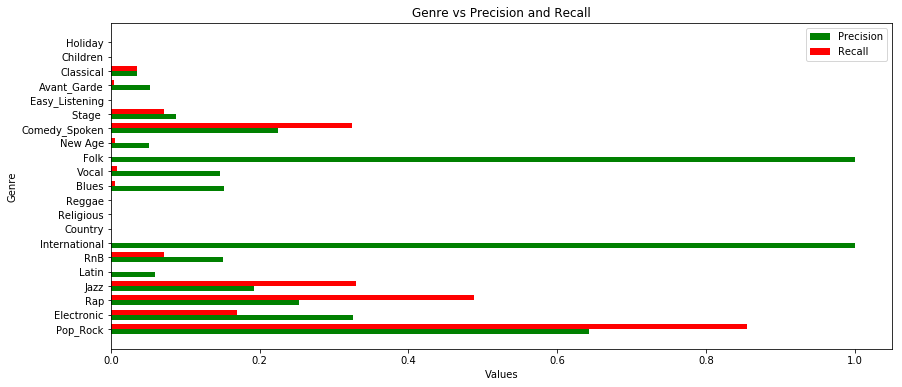

In [134]:
# Setting up the plot dimensions and the width of the bars
fig, ax = plt.subplots(figsize=(14, 6))
bar_width = 0.35
genres = Multiclass_resampled_pd['genre']
y_positions = range(len(genres))

# Create bars for precision and recall
ax.barh([y - bar_width/2 for y in y_positions], Multiclass_resampled_pd['Precision'], height=bar_width, label='Precision', color='green')
ax.barh([y + bar_width/2 for y in y_positions], Multiclass_resampled_pd['Recall'], height=bar_width, label='Recall', color='red')

# Setting titles and labels
ax.set_title('Genre vs Precision and Recall')
ax.set_xlabel('Values')
ax.set_ylabel('Genre')
ax.set_yticks(y_positions)
ax.set_yticklabels(genres)
ax.legend()

In [39]:
# Run this cell before closing the notebook or kill your spark application by hand using the link in the Spark UI

stop_spark()